# Intro

Welcome to the interactive labeling notebook!

The notebook proceeds as follows:

1. **Import** libraries
2. Define **paths** to data
3. **Label** ROI images using a simple GUI
5. **Visualize** results
6. **Save** results


- If you need to restart a session, don't worry. Your results are continuously saved in the CSV file and you can just start from where you left off.
- We recommend labeling one session at a time so that the results can be saved with the data.

# Import libraries

Widen the notebook

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

Import basic libraries

In [2]:
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt

Import `roicat`

In [3]:
%load_ext autoreload
%autoreload 2
import roicat

# Find paths to data

##### Prepare list of paths to data

In this example we are using suite2p output files, but other data types can be used (CaImAn, etc.) \
See the notebook on ingesting diverse data: https://github.com/RichieHakim/ROICaT/blob/main/notebooks/jupyter/other/demo_custom_data_importing.ipynb

Make a list containing the paths to all the input files.

In this example we are using suite2p, so the following are defined:
1. `paths_allStat`: a list to all the stat.npy files
2. `paths_allOps`: a list with ops.npy files that correspond 1-to-1 with the stat.npy files

In [4]:
dir_data = r'/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/20230420/'


path_stat = str(Path(dir_data) / 'stat.npy')
path_ops = str(Path(dir_data) / 'ops.npy')

data = roicat.data_importing.Data_suite2p(
    paths_statFiles=[path_stat],
    paths_opsFiles=[path_ops],
    new_or_old_suite2p='new',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 1 FOV images.
Completed: Set FOV_images for 1 sessions successfully.
Importing spatial footprints from stat files.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


# Label data

How to use this GUI:
- Each image will be shown one at a time. You can go to previous and next images by using the ***Left*** and ***Right*** arrow keys, and can close the GUI by pressing the ***Escape*** key.
- Label the image by pressing any key on your keyboard. This key will be used as the label. After each key press, the following occurs:
    1. The results will be saved as a CSV file at `path_csv` (will be a temporary file if not specified)
    2. The results will also be stored in the python object as `Image_labeler_obj.labels_`.
    2. The GUI should progress to the next image.
    3. Finish labeling by closing out of the GUI window or pressing the user defined '`end_key`' (***Escape*** by default).
- The results are stored in a temporary CSV file with two columns: 'index' and 'label'. This file can be used to recover lost labeling session data. We will save more comprehensive results files at the end of the notebook.
    - **'index'**: The index within the data object. 0-indexed.
    - **'label'**: The key pressed for that image in the labeling GUI.
- To start at a different image index than 0, change the `start_index` argument.

In [54]:
images = data.ROI_images[0]

## Run the Image_labeler class
with roicat.helpers.Image_labeler(
    image_array=images, 
    start_index=0,  ## Change the starting image index here.
    path_csv=None,  ## If None, then a temporary path will be used.
    resize_factor=10.0,  
    verbose=True,
    key_end='Escape',  ## Closes GUI
    key_prev='Left',  ## Goes to previous image
    key_next='Right',  ## Goes to next image
) as labeler:  ## Running this object within a context manager allows it to crash gracefully
    labeler.run()
    
path_csv = labeler.path_csv
labels = labeler.get_labels(kind='dataframe')

print(f"Number of labeled ROIs: {len(labels['index'])}")
print(f"path to csv file: {path_csv}")

Image 0: 0
Image 1: 1
Image 2: 0
Image 3: 0
Image 4: 1
Image 5: 0
Image 6: 0
Image 7: 1
Image 8: 0
Image 9: 0
Image 10: 0
Image 11: 0
Image 12: 0
Image 13: 1
Image 14: 1
Image 15: 0
Image 16: 1
Image 17: 1
Image 18: 1
Image 19: 0
Image 20: 0
Image 21: 1
Image 22: 0
Image 23: 1
Image 24: 1
Image 25: 0
Image 26: 0
Image 27: 1
Image 28: 0
Image 29: 1
Image 30: 1
Image 31: 0
Image 32: 1
Image 33: 0
Image 34: 1
Image 35: 0
Image 36: 1
Image 37: 1
Number of labeled ROIs: 38
path to csv file: /tmp/roicat_labels_20230617_173755.csv


# Visualize results

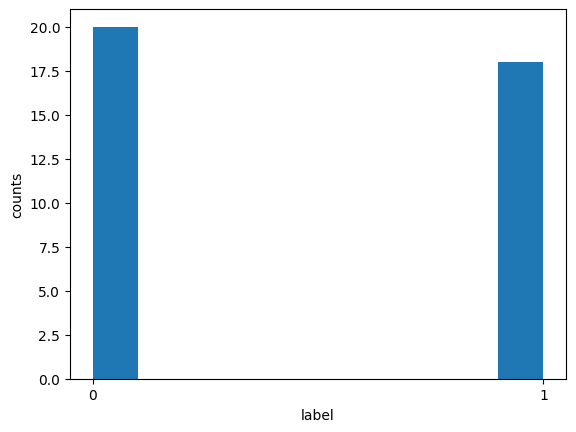

In [55]:
plt.figure()
plt.hist(labels['label']);
plt.xlabel('label');
plt.ylabel('counts');

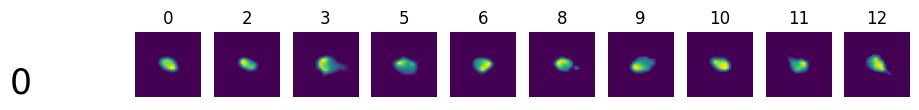

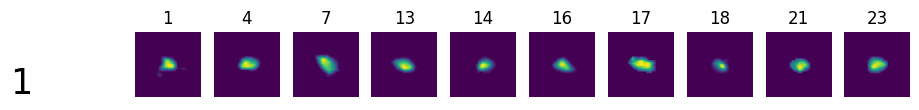

In [58]:
roicat.visualization.display_labeled_ROIs(
    images=images,
#     labels=labels['label'].astype(np.int64),
    labels=labels,
    max_images_per_label=10,
    figsize=(10, 3),
    fontsize=25,
    shuffle=False,
)

# Save results

The results file can be opened using any of the following methods:
1. `roicat.helpers.pickle_load(path)`
2. `np.load(path)`
3. 
``` 
import pickle
with open(path_save, mode='rb') as f:
    test = pickle.load(f)
  ```

##### Make the results dictionary

In [211]:
data_info = data.serializable_dict  ## pull out the data from the data object into a dictionary
[data_info.pop(key) for key in ['ROI_images', 'spatialFootprints'] if key in data_info]  ## remove the large data items from the data object

results = {
    'labels': labels,
    'images': images,
    'data_info': data_info,
}

##### Save the results dictionary

In [212]:
dir_save = r'/home/rich/Desktop/'
filename_save = 'test'

path_save = str(Path(dir_save).resolve() / (filename_save + '.ROICaT.labeling.results' + '.pkl'))
print(f'path_save: {path_save}')

roicat.helpers.pickle_save(results, path_save)

path_save: /home/rich/Desktop/test.ROICaT.labeling.results.pkl


# Thank you
If you encountered any difficulties, please let us know at the issues page: https://github.com/RichieHakim/ROICaT/issues

---
# Extras

## Merge and convert CSV files into a results file

##### Make labels dataframe

In [105]:
import csv

path_csv = r'/home/rich/Desktop/test.csv'

with open(path_csv, 'r') as f:
    lines = np.array([line for line in csv.reader(f)], dtype=str)
    labels = {}
    labels['index'] = np.array(lines[1:, 0], dtype=np.int64)
    labels['label'] = lines[1:, 1]

##### Make images array

In [111]:
dir_data = r'/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_0322R/statFiles/20230420/'


path_stat = str(Path(dir_data) / 'stat.npy')
path_ops = str(Path(dir_data) / 'ops.npy')

data = roicat.data_importing.Data_suite2p(
    paths_statFiles=[path_stat],
    paths_opsFiles=[path_ops],
    new_or_old_suite2p='new',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

images = data.ROI_images[0]

Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 1 FOV images.
Completed: Set FOV_images for 1 sessions successfully.
Importing spatial footprints from stat files.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]

Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


##### Make the results dictionary

In [112]:
data_info = data.serializable_dict  ## pull out the data from the data object into a dictionary
[data_info.pop(key) for key in ['ROI_images', 'spatialFootprints'] if key in data_info]  ## remove the large data items from the data object

results = {
    'labels': labels,
    'images': images,
    'data_info': data_info,
}

##### Save the results dictionary

In [ ]:
dir_save = r'/home/rich/Desktop/'
filename_save = 'test'

path_save = str(Path(dir_save).resolve() / (filename_save + '.ROICaT.labeling.results' + '.pkl'))
print(f'path_save: {path_save}')

roicat.helpers.pickle_save(results, path_save)